Here, we intend to see if using a GPU can reduce the training time of our FCN model.

In [33]:
import torch, torchvision
torch.__version__, torchvision.__version__

('2.0.0+cu118', '0.15.1+cu118')

In [34]:
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

In [35]:
from timeit import default_timer as timer

#### Getting torchvision dataset
`torchvision` provides some datasets that we can import to train our models. Here, we will use FashionMNIST dataset for demonstration. The returned variable is of type `Dataset` and has both features and the label of the sample at each index of the dataset.

In [36]:
train_data = torchvision.datasets.FashionMNIST(root="data",
                                               train=True, # download only training dataset
                                               download=True,
                                               transform=torchvision.transforms.ToTensor(),
                                               target_transform=None)

test_data = torchvision.datasets.FashionMNIST(root="data",
                                               train=False, # download only test dataset
                                               download=True,
                                               transform=torchvision.transforms.ToTensor(),
                                               target_transform=None)

In [37]:
first_image, first_targe_label = train_data[0]
first_image.shape, first_targe_label

(torch.Size([1, 28, 28]), 9)

In [38]:
from torch.utils.data import DataLoader

BATCH_SIZE = 64

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x20e9c17a980>,
 <torch.utils.data.dataloader.DataLoader at 0x20e9c17a650>)

Let's see how to interact with the dataloader. As mentioned before, `DataLoader` turns our dataset into a Python iterable.

In [39]:
len(train_dataloader), len(test_dataloader)

(938, 157)

In [40]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch

(torch.Size([64, 1, 28, 28]),
 tensor([4, 2, 3, 3, 5, 8, 1, 3, 9, 2, 9, 3, 5, 9, 1, 5, 2, 2, 3, 9, 4, 0, 6, 8,
         2, 5, 1, 7, 6, 6, 9, 2, 4, 0, 7, 1, 9, 8, 9, 7, 9, 9, 3, 3, 5, 1, 4, 3,
         6, 9, 5, 6, 8, 4, 9, 8, 1, 1, 1, 0, 9, 5, 7, 0]))

Turns out, the `DataLoader` class converts the torchvision dataset features into the shape of B x C x H x W.

#### Build a fully-connected network.
Here, we will attempt to make classification of images based on fully-connected layers only.

In [41]:
class FashionMNIST_classifier(torch.nn.Module):

    def __init__(self, input_shape: int, hidden_units : int, output_shape : int):
        super().__init__()
        self.seq_layer_stack = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(in_features=input_shape, out_features=hidden_units),
            torch.nn.Linear(in_features=hidden_units, out_features=output_shape)
        )
    
    def forward(self, x : torch.Tensor) -> torch.Tensor:
        return self.seq_layer_stack(x)


#### Training
Train the network using `DataLoader` object. The training loop algorithm looks as below:<br>
- Loop through epochs.
    - for training batch 0 to ...
        - calculate `training_loss` for this batch using loss function.
        - calculate gradients using `loss.backward()`.
        - update parameters using `optimizer.step()`.
    - for testing batch 0 to ...
        - calculate `test_loss` for this batch.
        

In [42]:
from helper_functions import accuracy_fn
from utils import print_training_time

from tqdm import tqdm

In [43]:
len(train_dataloader)

938

Checking output format before training.


In [44]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [45]:
# create a classifier.
# shape of a FashionMNIST image is 28*28 and there are 10 different output labels.
torch.manual_seed(42)
_classifier = FashionMNIST_classifier(input_shape=28*28, hidden_units=10, output_shape=10)
_classifier = _classifier.to(device=device)

with torch.inference_mode():
    _classifier.eval()
    for batch_num, (X, y) in enumerate(train_dataloader):
        # move the data to the respective device
        X, y = X.to(device=device), y.to(device=device)
        y_pred_batch = _classifier(X)
        break
# check the shape of the batch output
y_pred_batch.shape

torch.Size([64, 10])

Let's modularize model training and testing loops.

In [46]:
def training_step(model: torch.nn.Module,
                  data_loader : torch.utils.data.DataLoader,
                  loss_function : torch.nn.Module,
                  optimizer : torch.optim,
                  accuracy_func,
                  device : torch.device = device):
    """
    Trains a passed torch.nn.Module object using the passed DataLoader object.
    """
    cumulative_tr_loss, cumulative_tr_acc = 0, 0
    
    model.train()
    for batch_num, (X, y) in enumerate(train_dataloader):
        
        X, y = X.to(device=device), y.to(device=device)

        y_pred_batch = model(X)

        batch_loss = loss_function(y_pred_batch, y)
        tr_acc = accuracy_func(y, y_pred_batch.argmax(dim = 1))
        cumulative_tr_acc += tr_acc
        
        # accumulate training loss for an epoch for plotting purpose
        # ensure to detach the variable value from the computation graph
        cumulative_tr_loss += batch_loss.to("cpu").item()

        # wipe out garbage gradients accumulated
        optimizer.zero_grad()

        # backpropagation to calculate gradients
        batch_loss.backward()

        # optimizer the model parameters once per batch
        optimizer.step()
      
    
    # average training loss per batch
    avg_tr_loss_per_batch = cumulative_tr_loss/len(train_dataloader)
    avg_tr_acc_per_batch = cumulative_tr_acc/len(train_dataloader)

    print("Avg tr loss/batch: ", round(avg_tr_loss_per_batch,3), "Avg tr acc/batch: ", round(avg_tr_acc_per_batch,3))
    return avg_tr_acc_per_batch, avg_tr_loss_per_batch


In [47]:
def test_step(model: torch.nn.Module,
                data_loader : torch.utils.data.DataLoader,
                loss_function : torch.nn.Module,
                accuracy_func,
                device : torch.device = device):
    """
    Performs a testing loop using the passed torch.nn.Module object over the passed DataLoader object.
    """

    cumulative_test_loss, cumulative_test_acc = 0, 0

    model.eval()
    with torch.inference_mode():

        for batch_num, (X,y) in enumerate(test_dataloader):

            X, y = X.to(device=device), y.to(device=device)

            test_preds = model(X)
            test_loss = loss_function(test_preds, y)
            cumulative_test_loss += test_loss.item()

            test_acc = accuracy_func(y, test_preds.argmax(dim = 1))
            cumulative_test_acc += test_acc
        
        # calculate average test loss and test accuracy per batch
        avg_test_loss_per_batch = cumulative_test_loss/len(test_dataloader)
        avg_test_acc_per_batch = cumulative_test_acc/len(test_dataloader)
        
        print("Avg test loss/batch:", round(avg_test_loss_per_batch,3),"Average test acc/batch:", round(avg_test_acc_per_batch,3))
    
    return avg_test_acc_per_batch, avg_test_loss_per_batch

In [48]:
# create a classifier.
# shape of a FashionMNIST image is 28*28 and there are 10 different output labels.
torch.manual_seed(42)
torch.cuda.manual_seed(42)

classifier = FashionMNIST_classifier(input_shape=28*28, hidden_units=10, output_shape=10)
classifier = classifier.to(device=device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params= classifier.parameters(), lr= 0.005)

epochs = 20
epochs_ctr = []
avg_tr_loss_per_batch_list = []
avg_tr_acc_per_batch_list = []
avg_test_loss_per_batch_list = []
avg_test_acc_per_batch_list = []



for epoch in range(0, epochs):
    
    epoch_training_time_start = timer()

    print("\nEpoch ", epoch)
    epochs_ctr.append(epoch)
    cumulative_training_loss_per_epoch = 0
    cumulative_tr_acc_per_epoch = 0

    ### modular training step ###
    avg_tr_acc_per_batch, avg_tr_loss_per_batch = training_step(model=classifier,
                                                                data_loader=train_dataloader,
                                                                loss_function=loss_function,
                                                                optimizer=optimizer,
                                                                accuracy_func= accuracy_fn,
                                                                device=device)

    # store average loss and accuracy for plot
    avg_tr_acc_per_batch_list.append(avg_tr_acc_per_batch)
    avg_tr_loss_per_batch_list.append(avg_tr_loss_per_batch)

    ### modular test loop ###
    avg_test_acc_per_batch, avg_test_loss_per_batch = test_step(model=classifier,
                                                                data_loader=test_dataloader,
                                                                loss_function=loss_function,
                                                                accuracy_func=accuracy_fn,
                                                                device=device)
          
    # store average loss and accuracy for plot
    avg_test_loss_per_batch_list.append(avg_test_loss_per_batch)
    avg_test_acc_per_batch_list.append(avg_test_acc_per_batch)

    
    # calculate epoch training time
    epoch_training_end_time = timer()
    total_training_time = print_training_time(start=epoch_training_time_start, end=epoch_training_end_time, device=str(next(classifier.parameters())))



Epoch  0
Avg tr loss/batch:  1.475 Avg tr acc/batch:  57.086
Avg test loss/batch: 0.958 Average test acc/batch: 68.332
Epoch training time: 10.325 seconds.

Epoch  1
Avg tr loss/batch:  0.82 Avg tr acc/batch:  72.776
Avg test loss/batch: 0.759 Average test acc/batch: 73.955
Epoch training time: 10.302 seconds.

Epoch  2
Avg tr loss/batch:  0.692 Avg tr acc/batch:  76.714
Avg test loss/batch: 0.675 Average test acc/batch: 76.851
Epoch training time: 10.161 seconds.

Epoch  3
Avg tr loss/batch:  0.627 Avg tr acc/batch:  79.003
Avg test loss/batch: 0.628 Average test acc/batch: 78.404
Epoch training time: 10.142 seconds.

Epoch  4
Avg tr loss/batch:  0.586 Avg tr acc/batch:  80.319
Avg test loss/batch: 0.595 Average test acc/batch: 79.598
Epoch training time: 10.374 seconds.

Epoch  5
Avg tr loss/batch:  0.558 Avg tr acc/batch:  81.247
Avg test loss/batch: 0.571 Average test acc/batch: 80.583
Epoch training time: 10.677 seconds.

Epoch  6
Avg tr loss/batch:  0.537 Avg tr acc/batch:  81.8

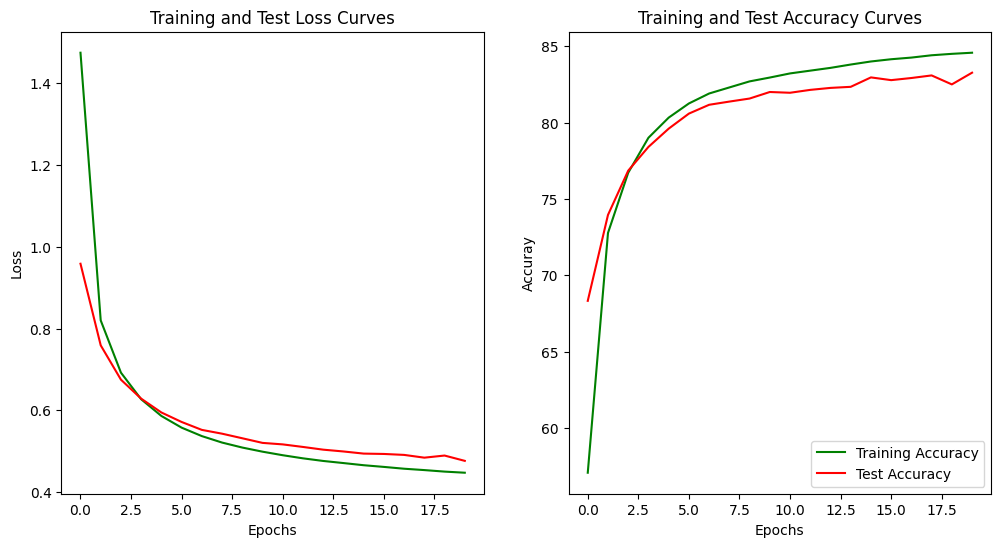

In [49]:
plt.figure(figsize=(12,6))

# subplot 1
plt.subplot(1,2,1) 
plt.title("Loss")
plt.plot(epochs_ctr, avg_tr_loss_per_batch_list, "g", label = "Training Loss")
plt.plot(epochs_ctr, avg_test_loss_per_batch_list, "r", label = "Test Loss")
plt.title("Training and Test Loss Curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")

# subplot 2
plt.subplot(1,2,2)
plt.title("Test")
plt.title("Accuracy")
plt.plot(epochs_ctr, avg_tr_acc_per_batch_list, "g", label = "Training Accuracy")
plt.plot(epochs_ctr, avg_test_acc_per_batch_list, "r", label = "Test Accuracy")
plt.title("Training and Test Accuracy Curves")
plt.xlabel("Epochs")
plt.ylabel("Accuray")

plt.legend()
plt.show()

As seen above, the training time for each epoch is around 10 seconds i.e., it has decreased as compared to training on CPU. GPUs speed up training by being more efficient at matrix multiplication which is performed by all types of neural network layers. Also, the NN model used here is small and the number of training samples is in thousands. Hence, there is little improvement room. If the number of samples per epoch were very large and the layer were a very complex network, this improvement in training time would have been huge.<br><br>
Sometimes, training on CPU can be faster than training on GPU<br>
- if the overhead of copying data from CPU to GPU and vice-versa is more than the speed-up provided by the parallel matrix computations on GPU.<br>
- if the CPU used is a very fast one as compared to the used GPU (which is very unlikely in practice.)